### Some initial model constructions using NUMPY PANDAS and some other stuff

In [20]:
import pandas as pd
from pathlib import Path

BASE = Path("umbc_data/csv")  # adjust if needed

# --- Load CSVs ---
cc = pd.read_csv(BASE / "completed_courses.csv")          # has :START_ID(Student), :END_ID(Course), grade, ...
ti = pd.read_csv(BASE / "textbook_interactions.csv")      # has :START_ID(Student), courseId, duration:int, ...

# --- Normalize column names once ---
cc = cc.rename(columns={
    ":START_ID(Student)": "studentId",
    ":END_ID(Course)": "courseId",
    "difficulty:int": "difficulty",
    "timeSpent:int": "timeSpent",
})
ti = ti.rename(columns={
    ":START_ID(Student)": "studentId",
})

# Ensure the key columns exist
assert {"studentId","courseId","grade"}.issubset(cc.columns), f"completed_courses columns: {cc.columns}"
assert {"studentId","courseId"}.issubset(ti.columns), f"textbook_interactions columns: {ti.columns}"

# --- Coerce duration to numeric (supports 'duration:int' or 'duration') ---
if "duration:int" in ti.columns:
    ti["duration"] = pd.to_numeric(ti["duration:int"], errors="coerce")
elif "duration" in ti.columns:
    ti["duration"] = pd.to_numeric(ti["duration"], errors="coerce")
else:
    raise KeyError("No 'duration' or 'duration:int' column in textbook_interactions.csv")

# --- Aggregate total duration per (student, course) ---
dur = (
    ti.groupby(["studentId", "courseId"], as_index=False)["duration"]
      .sum()
      .rename(columns={"duration": "totalDuration"})
)

# --- Join grade per (student, course) with summed duration ---
out = (
    cc[["studentId", "courseId", "grade","difficulty","timeSpent"]]
    .merge(dur, on=["studentId", "courseId"], how="left")
    .fillna({"totalDuration": 0})
)

# Preview result
display(out.head(10))

# Optional: quick sanity checks
print("Rows in completed:", len(cc), "| unique (student,course):", cc[["studentId","courseId"]].drop_duplicates().shape[0])
print("Rows in interactions:", len(ti))
print("Rows in merged output:", len(out))


,studentId,courseId,grade,difficulty,timeSpent,totalDuration
0,EE11092,CSNN 100,C+,4,9,843
1,KG30374,BBBB 100,B,2,5,548
2,KG30374,CSDD 200,C+,3,5,935
3,KG30374,BBBB 100-3,C,3,7,496
4,KG30374,BFFF 100,B+,3,5,687
5,FS65039,CSKK 200-4,D+,4,6,469
6,FS65039,BFFF 100-4-1,B-,3,7,446
7,FS65039,CSVV 100,B,3,7,646
8,FS65039,CSKK 200,C,4,8,898
9,FS65039,BEEE 100,B+,3,6,661


Rows in completed: 4327 | unique (student,course): 4327
Rows in interactions: 716059
Rows in merged output: 4327


In [29]:
import numpy as np

grade_map = {
    "A":4.0, "A-":3.7,
    "B+":3.3, "B":3.0, "B-":2.7,
    "C+":2.3, "C":2.0, "C-":1.7,
    "D+":1.3, "D":1.0, "D-":0.7,
    "F":0.0, "W":0.0   # tweak as you prefer for W/withdraw
}

# keep original, add a GPA column
out["gpa"] = (
    out["grade"]
      .astype(str).str.strip().str.upper()
      .map(grade_map)
)

# OR, if you want to overwrite the grade column itself:
# df["grade"] = df["grade"].astype(str).str.strip().str.upper().map(grade_map)


In [16]:
out.head()

,studentId,courseId,grade,totalDuration,gpa
0,EE11092,CSNN 100,C+,843,2.3
1,KG30374,BBBB 100,B,548,3.0
2,KG30374,CSDD 200,C+,935,2.3
3,KG30374,BBBB 100-3,C,496,2.0
4,KG30374,BFFF 100,B+,687,3.3


[]

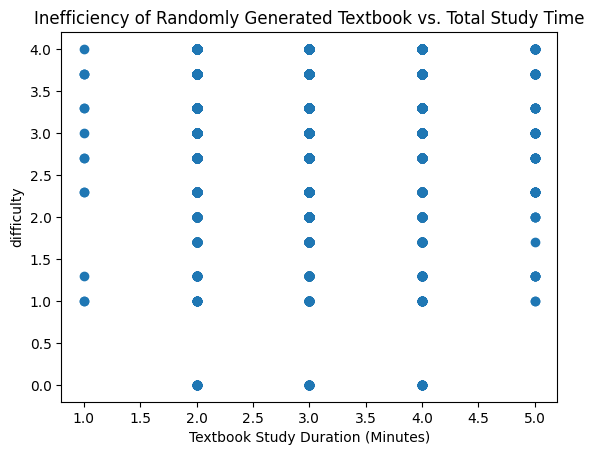

In [30]:
import matplotlib.pyplot as plt

plt.scatter(out['difficulty'],out['gpa'])
plt.xlabel('Textbook Study Duration (Minutes)')
plt.ylabel('difficulty')
plt.title('Inefficiency of Randomly Generated Textbook vs. Total Study Time')
plt.plot()